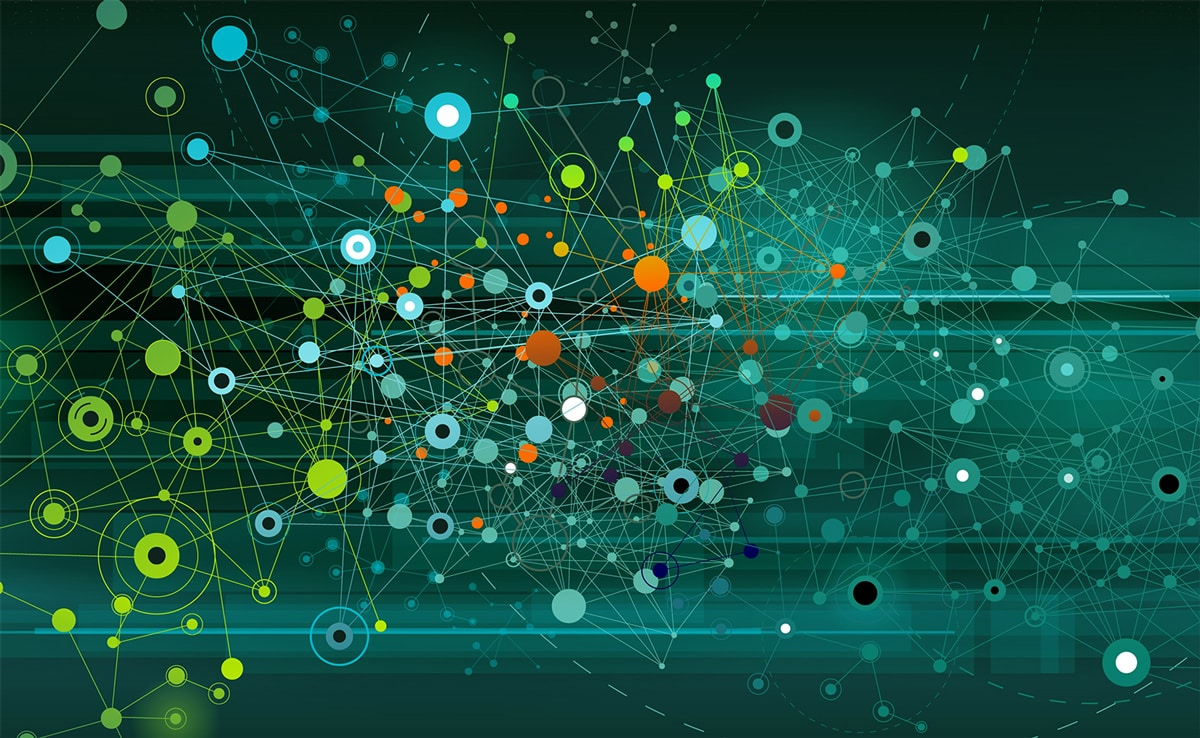
# Livrable 1

## Classification binaire

### Groupe de projet :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi
<br>
<br>
### Introduction

Dans un premier temps, ce premier livrable consiste en la réalisation d'un classificateur binaire. Ce classificateur à pour role de séparé les datasets fournis :
- Photo
- Painting
- Schematics
- Sketch
- Texte

en deux groupe, un groupe "photo" et un groupe "pas photo".

#### Import

L'ensemble des imports des bibliothèques pour mener à bien ce projet.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import fidle.pwk as pwk

In [7]:
import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# dataset_url = "G:\EXIA\A5\Data-science\Projet-Leyenda\Datasets"

# data_dir = tf.keras.utils.get_file('Photo', origin=dataset_url, extract=True)
# data_dir = pathlib.Path(data_dir)
data_dir =  "/Users/cpt_n2mo/Desktop/GitHub/Projet-DataScienceA5/datasets"

image_h = 180
image_w = 180
batch_s = 32

train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.8, 
  subset = "training",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.2,
  subset = "validation",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)



Found 41405 files belonging to 5 classes.
Using 8281 files for training.
Found 41405 files belonging to 5 classes.
Using 8281 files for validation.


### Trier l'image en noir et blanc

In [12]:
def palette(img):
    """
    Return palette in descending order of frequency
    """
    arr = np.asarray(img)
    palette, index = np.unique(asvoid(arr).ravel(), return_inverse=True)
    palette = palette.view(arr.dtype).reshape(-1, arr.shape[-1])
    count = np.bincount(index)
    order = np.argsort(count)
    return palette[order[::-1]]

def asvoid(arr):
    """View the array as dtype np.void (bytes)
    This collapses ND-arrays to 1D-arrays, so you can perform 1D operations on them.
    http://stackoverflow.com/a/16216866/190597 (Jaime)
    http://stackoverflow.com/a/16840350/190597 (Jaime)
    Warning:
    >>> asvoid([-0.]) == asvoid([0.])
    array([False], dtype=bool)
    """
    arr = np.ascontiguousarray(arr)
    return arr.view(np.dtype((np.void, arr.dtype.itemsize * arr.shape[-1])))

def removeBlackAndWhite():
    for image in data_dir:
        img = Image.open(image, 'r')
        print(palette(img))
        # if que du noir, remove l'image

